<a href="https://colab.research.google.com/github/Michaelzats/Assets-optimisation-predictor/blob/main/Assets_optimisation_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
!pip install -q yfinance
!pip install pandas-datareader
!pip install pulp
!pip install --upgrade pandas
!pip install PyPortfolioOpt



In [157]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import statistics
import seaborn as sns
from pandas_datareader import data
from pulp import *
import requests
from pandas_datareader import data as pdr
import yfinance as yfin
from pypfopt.expected_returns import mean_historical_return
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.efficient_frontier import EfficientFrontier 
from pypfopt import risk_models 
from pypfopt import expected_returns
from pypfopt.cla import CLA
import pypfopt.plotting as pplt
from matplotlib.ticker import FuncFormatter



In [259]:
assets = ['AAPL','MSFT','FB','SPCE']


In [260]:
initial_date = "2016-04-20"
today = datetime.today().strftime('%Y-%m-%d')


In [261]:
df_prices = pd.DataFrame()


In [262]:
# We give the function the empty dataframe, the name of the assets, the initial date and the end date:


def datosYahoo(dataframe,asset_list,start,finish):
    for i in asset_list:
        dataframe[i] = pdr.get_data_yahoo(i, start= initial_date , end=finish)["Adj Close"]
    return dataframe
df = datosYahoo(df_prices,assets,initial_date,today)
df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,AAPL,MSFT,FB,SPCE
Date,,,,
2016-04-20,24.763456,50.562614,112.419998,NaN
2016-04-21,24.495319,50.735428,113.440002,NaN
2016-04-22,24.428288,47.097172,110.559998,NaN
2016-04-25,24.289591,47.397331,110.099998,NaN
2016-04-26,24.120852,46.787910,108.760002,NaN
...,...,...,...,...
2022-04-28,163.639999,289.630005,205.729996,7.90
2022-04-29,157.649994,277.519989,200.470001,7.49
2022-05-02,157.960007,284.470001,211.130005,7.89


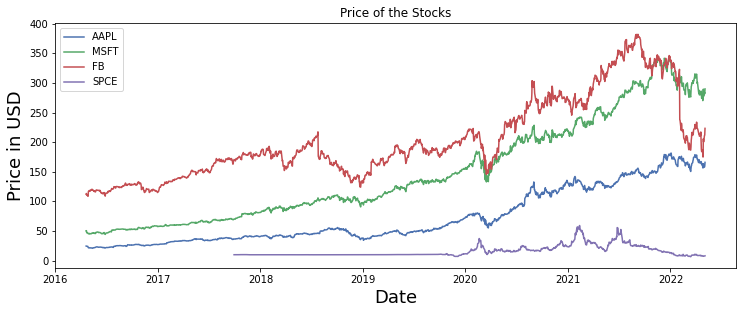

In [263]:
plt.figure(figsize=(12.2,4.5)) 
for i in df.columns.values:
    plt.plot( df[i],  label=i)
plt.title('Price of the Stocks')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price in USD',fontsize=18)
plt.legend(df.columns.values, loc='upper left')
plt.show()

In [264]:
#Checking if any NaN values in the data
nullin_df = pd.DataFrame(df,columns=assets)
print(nullin_df.isnull().sum())


AAPL      0
MSFT      0
FB        0
SPCE    365
dtype: int64


In [266]:
#Annluaized Return
mu = expected_returns.mean_historical_return(df) 
#Sample Variance of Portfolio
Sigma = risk_models.sample_cov(df)

In [267]:
#Max Sharpe Ratio - Tangent to the EF
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) #weight bounds in negative allows shorting of stocks
sharpe_pfolio=ef.max_sharpe() #May use add objective to ensure minimum zero weighting to individual stocks
sharpe_pwt=ef.clean_weights()
print(sharpe_pwt)

OrderedDict([('AAPL', 0.51603), ('MSFT', 0.48397), ('FB', 0.0), ('SPCE', 0.0)])


In [268]:
ef.portfolio_performance(verbose=True, risk_free_rate = 0.27)
# 2year risk free rate - Treasury Yield 

Expected annual return: 35.4%
Annual volatility: 26.3%
Sharpe Ratio: 1.27


/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  UserWarning,


(0.3536577893658101, 0.26344511133012294, 1.2665172934171616)

In [269]:
#Min Volatility Portfolio
ef1 = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) #weight bounds in negative allows shorting of stocks
minvol=ef1.min_volatility()
minvol_pwt=ef1.clean_weights()
print(minvol_pwt)

OrderedDict([('AAPL', 0.30998), ('MSFT', 0.55474), ('FB', 0.12897), ('SPCE', 0.00632)])


In [270]:
ef1.portfolio_performance(verbose=True, risk_free_rate = 0.27)

Expected annual return: 31.6%
Annual volatility: 25.9%
Sharpe Ratio: 0.18


(0.31631575017993485, 0.2587421508848747, 0.179003498353628)

In [271]:
from pypfopt.cla import CLA
from pypfopt import discrete_allocation

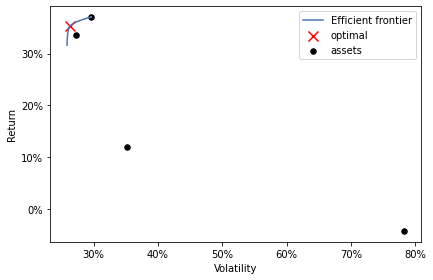

In [272]:
cl_obj = CLA(mu, Sigma)
ax = pplt.plot_efficient_frontier(cl_obj, showfig = False)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

In [276]:
latest_prices = discrete_allocation.get_latest_prices(df)
# Allocate Portfolio Value in $ as required to show number of shares/stocks to buy, also bounds for shorting will affect allocation
#Min Volatility Portfolio Allocation $10000
allocation_minv, rem_minv = discrete_allocation.DiscreteAllocation(minvol_pwt, latest_prices, total_portfolio_value=10000).lp_portfolio() 
print(allocation_minv)
print("Leftover Fund value in$ after building minimum volatility portfolio is ${:.2f}".format(rem_minv))


{'AAPL': 18, 'MSFT': 19, 'FB': 6, 'SPCE': 8}
Leftover Fund value in$ after building minimum volatility portfolio is $95.48


In [275]:
#Max Sharpe Ratio Portfolio Allocation $10000
latest_prices1 = discrete_allocation.get_latest_prices(df)
allocation_shp, rem_shp = discrete_allocation.DiscreteAllocation(sharpe_pwt, latest_prices1, total_portfolio_value=10000).lp_portfolio() 
print(allocation_shp)
print("Leftover Fund value in$ after building Max Sharpe ratio portfolio is ${:.2f}".format(rem_shp))



{'AAPL': 30, 'MSFT': 17}
Leftover Fund value in$ after building Max Sharpe ratio portfolio is $89.74
